In [81]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from alns import ALNS
from alns.accept import HillClimbing
from alns.stop import MaxRuntime
from alns.weights import SimpleWeights

from tsp_as.increasing_scv import increasing_scv
from tsp_as.classes import Params, Solution
from tsp_as.destroy_operators import adjacent_destroy, random_destroy
from tsp_as.plot import plot_graph
from tsp_as.repair_operators import greedy_insert
from diagnostics import cost_breakdown, tabulate


def solve_tsp_as(params, seed: int, max_runtime: int, **kwargs):
    """
    Solve the instance.
    """
    rng = rnd.default_rng(seed)

    alns = ALNS(rng)
    alns.add_destroy_operator(random_destroy)
    alns.add_destroy_operator(adjacent_destroy)
    alns.add_repair_operator(greedy_insert)

    init = Solution(params, np.arange(1, params.dimension).tolist())  # ordered
    weights = SimpleWeights([5, 2, 1, 0.5], 2, 2, 0.8)
    accept = HillClimbing()
    stop = MaxRuntime(max_runtime)

    res = alns.iterate(init, weights, accept, stop, **kwargs)
    stats = res.statistics

    return res.best_state


def solve_tsp(_params, seed: int, max_runtime: int, **kwargs):
    """
    Solve the instance as TSP problem.
    """
    rng = rnd.default_rng(seed)
    params = deepcopy(_params)
    
    # Set omega idle and wait to zero to activate TSP solving
    params.omega_idle = 0
    params.omega_wait = 0
    params.omega_travel = 1

    alns = ALNS(rng)
    alns.add_destroy_operator(random_destroy)
    alns.add_destroy_operator(adjacent_destroy)
    alns.add_repair_operator(greedy_insert)

    init = Solution(params, np.arange(1, params.dimension).tolist())  # ordered
    weights = SimpleWeights([5, 2, 1, 0.5], 2, 2, 0.8)
    accept = HillClimbing()
    stop = MaxRuntime(max_runtime)

    res = alns.iterate(init, weights, accept, stop, **kwargs)
    stats = res.statistics

    return res.best_state

In [69]:
# Set path to instance (it uses only the coordinates)
# C instances are clustered, R instances are randomly distributed, 
# RC instances are randomly clustered
path = Path("instances/solomon/C102.txt")

MAX_DIM = 8 # Number of locations including depot

distance_params = {
    # Matrix of shape (max_dim, max_dim). If None, then the default is to
    # use the instance data to obtain the dimensions. If you want a pure
    # appointment scheduling problem, you can use np.zeros((max_dim, max_dim)).
    "distances": None,
    
    # SCVs are sampled for each entry (i, j) in the distances matrix from a
    # uniform distribution defined on (distances_scv_min, distances_scv_max).
    "distances_scv_min": 0.1,
    "distances_scv_max": 0.1,
}

service_params = {
    # Array of length (max_dim) to indicate service times at each location.
    # If None, then the default is used, which is the average travel time
    # to the nearest 10 customers. If you want a pure TSP problem, you can
    # use np.zeros(max_dim) so that there are no service times.
    "service": None,

    # For service times you can assign service time SCVs explicitly. If None,
    # then the default will be used (which is to sample from a uniform
    # distribution, see below). Otherwise, when an array is passed in then
    # those values will be used. E.g.:
    # "service_scv": np.ones(MAX_DIM),
    "service_scv": None,
    
    # SCVs are sampled for each entry i in the service times array from a
    # uniform distribution defined on (service_scv_min, service_scv_max).
    "service_scv_min": 1.1,
    "service_scv_max": 1.5,
}

objective_params = {
    # Weights of each part in the objective function. If you set omega_idle
    # and omega_wait to 0, then the algorithm will automatically solve a 
    # TSP problem without appointment scheduling.
    "omega_travel": 0.2,
    "omega_idle": 0.2,
    "omega_wait": 0.6,
    
    # Objective function to use throughout the algoritihm. One of 
    # - 'hto': heavy traffic, true optimal
    # - 'htt': heavy traffic, heavy traffic
    # - 'to': true optimal, true optimal (don't use this)
    # - 'htl': heavy traffic, true optimal with lag
    "objective": "htl", 
    "lag": 3, # lag value
}

# Specify instance characteristics
parameters = {
    "max_dim": MAX_DIM,
    **distance_params,
    **service_params,
    **objective_params,
}

In [93]:
# Select algorithm: one of the following:
# - solve_tsp_as: this is the main algorithm which solves TSP with scheduling
# - solve_tsp: solve the TSP without appointment scheduling
# - increasing_scv: order the clients in order of increasing SCV of service times
# - modified_tsp: solve the modified TSP, where edge weights are modified. # Not available yet
algorithm = increasing_scv

rng = rnd.default_rng(1)
params = Params.from_solomon(path, rng, **parameters)
best = algorithm(params, seed=42, max_runtime=5)

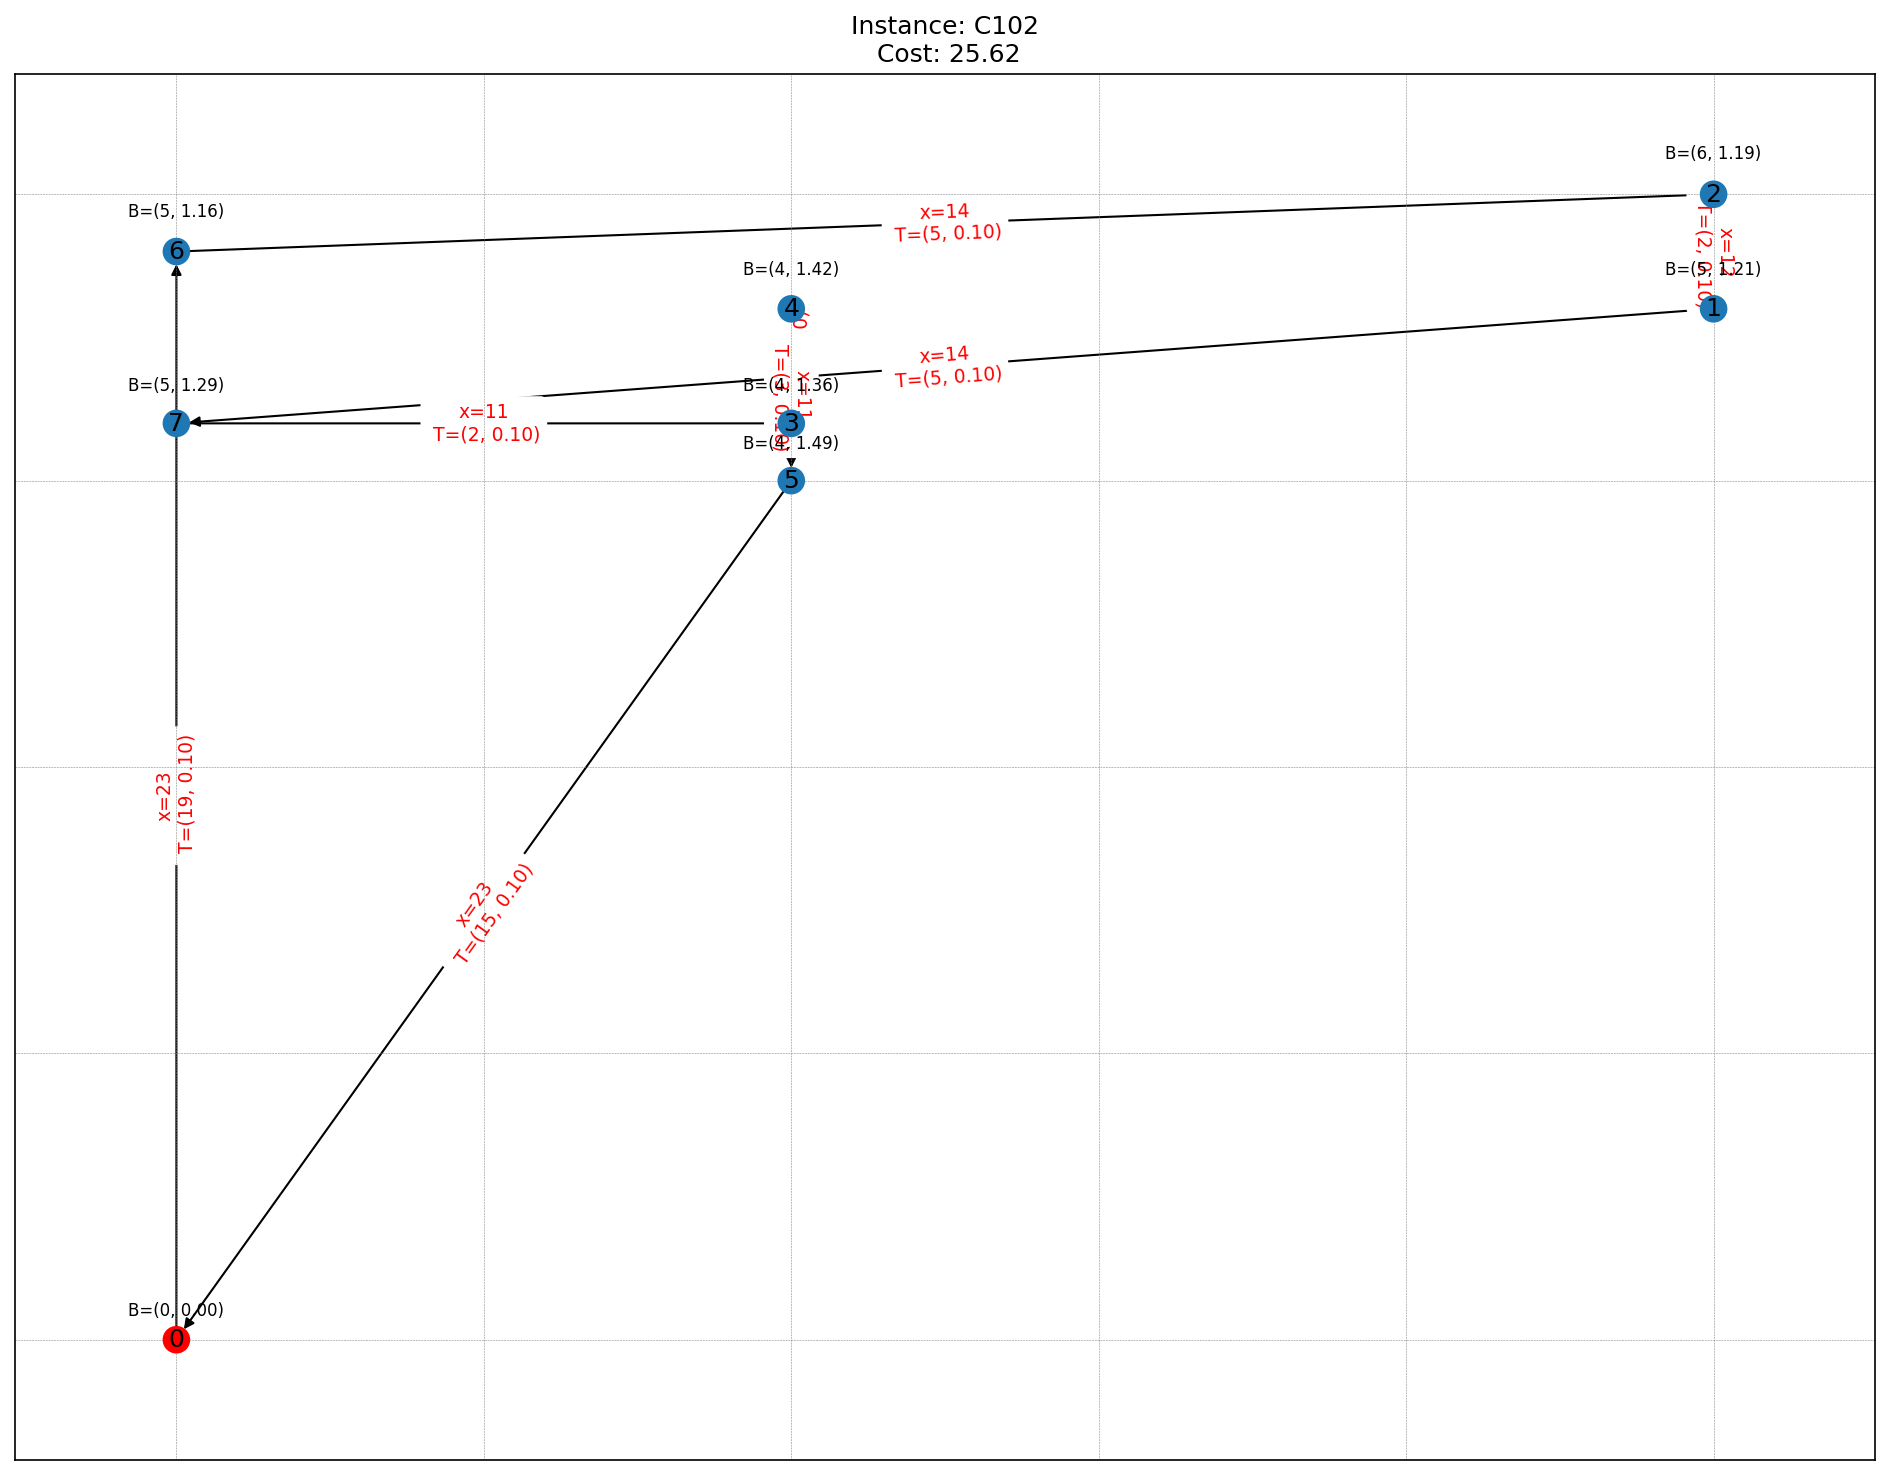

In [94]:
# Plot the solutions and save to file
fig, ax = plt.subplots(figsize=[16, 12], dpi=150)
plot_graph(ax, params, best)
plt.show()

fig.savefig(f"tmp/{path.stem}-dim{parameters['max_dim']}.svg")
plt.close()

In [95]:
headers, rows = cost_breakdown(best, params)
print(tabulate(headers, rows))

from  to  interappt. time  dist.  idle & wait
----  --  ---------------  -----  -----------
   0   6            23.25   19.0         1.66
   6   2            14.65    5.1         1.77
   2   1            12.37    2.0         2.02
   1   7            14.94   5.39         2.02
   7   3            11.02    2.0         1.85
   3   4            10.44    2.0          1.7
   4   5            11.62    3.0         1.72
   5   0             23.9  15.13         2.15


In [8]:
best.cost

24.187792196115517

In [9]:
params.service[np.newaxis, :].T

array([[0.        ],
       [5.25173975],
       [6.06927188],
       [4.16695226],
       [4.34760208],
       [4.48931781],
       [5.31397428],
       [4.73159802]])

In [17]:
params.distances

array([[ 0.        , 18.68154169, 20.61552813, 16.1245155 , 18.11077028,
        15.13274595, 19.        , 16.        ],
       [18.68154169,  0.        ,  2.        ,  3.60555128,  3.        ,
         4.24264069,  5.09901951,  5.38516481],
       [20.61552813,  2.        ,  0.        ,  5.        ,  3.60555128,
         5.83095189,  5.09901951,  6.40312424],
       [16.1245155 ,  3.60555128,  5.        ,  0.        ,  2.        ,
         1.        ,  3.60555128,  2.        ],
       [18.11077028,  3.        ,  3.60555128,  2.        ,  0.        ,
         3.        ,  2.23606798,  2.82842712],
       [15.13274595,  4.24264069,  5.83095189,  1.        ,  3.        ,
         0.        ,  4.47213595,  2.23606798],
       [19.        ,  5.09901951,  5.09901951,  3.60555128,  2.23606798,
         4.47213595,  0.        ,  3.        ],
       [16.        ,  5.38516481,  6.40312424,  2.        ,  2.82842712,
         2.23606798,  3.        ,  0.        ]])

In [16]:
# This is the matrix for U, where entry (i, j) means the servive time at B_i
# plus the travel time T_{ij} from i to j.
params.means

array([[ 0.        , 18.68154169, 20.61552813, 16.1245155 , 18.11077028,
        15.13274595, 19.        , 16.        ],
       [23.93328144,  5.25173975,  7.25173975,  8.85729102,  8.25173975,
         9.49438043, 10.35075926, 10.63690455],
       [26.68480001,  8.06927188,  6.06927188, 11.06927188,  9.67482316,
        11.90022378, 11.16829139, 12.47239612],
       [20.29146775,  7.77250353,  9.16695226,  4.16695226,  6.16695226,
         5.16695226,  7.77250353,  6.16695226],
       [22.45837236,  7.34760208,  7.95315336,  6.34760208,  4.34760208,
         7.34760208,  6.58367006,  7.17602921],
       [19.62206376,  8.7319585 , 10.3202697 ,  5.48931781,  7.48931781,
         4.48931781,  8.96145376,  6.72538579],
       [24.31397428, 10.41299379, 10.41299379,  8.91952555,  7.55004226,
         9.78611023,  5.31397428,  8.31397428],
       [20.73159802, 10.11676283, 11.13472226,  6.73159802,  7.56002514,
         6.967666  ,  7.73159802,  4.73159802]])